In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## How to run this
Instructions.

## Simulation parameters
We define some general parameters that will control the simulation. Altering these values can give very different results.

In [ ]:
# Parameters that control the simulation
population_size = 100
rate_per_infected_contact = 0.2  # 20% chance of becoming infected per infected contact
duration_of_infectivity = 2  #  Assume 2 time periods (this needs to be >1)
contact_number_parameter = 8  # Parameter determining the distribution of number of contacts per person
initial_prevalence_in_contacts = 0.0  # No contacts are infected at time 0 at start of the simulation
simulation_time = 20  # How many steps to simulate the population for

## Personal characteristics
Here we list which attributes we want to track for each person in the population.
These include facts about their infection status:
- are they infected or not
- is this a new infection
- when were they infected
- have they ever been infected in the past

as well their contacts:
- how many people this person is in contact with
- how many of those contacts are infected

In [ ]:
class Person:
    def __init__(self):
        """Initialise a new person."""
        self.infected = False
        self.time_of_infection = None
        self.ever_infected = False
        self.new_infection = False

        self.contacts = np.random.poisson(contact_number_parameter) 
        self.infected_contacts = 0

In [ ]:
def initialise_population(population_size):
    """Create a population with only one person infected."""
    population = [Person() for _ in range(population_size)]
    infect(population[0], 0)
    return population


def infect(person, time):
    person.infected = True
    person.time_of_infection = time
    person.ever_infected = True
    person.new_infection = True
    #person.contacts_if_infected = person.contacts

## Summary metrics for the population
At every step of the simulation, we compute some metrics across the whole population. 

In [ ]:
def summarise(population):
    stats = {
        "contacts": sum(person.contacts for person in population),
        "contacts_if_infected":  sum(person.contacts for person in population if person.infected),
        "infected": sum(person.infected for person in population),
        "new_infections": sum(person.new_infection for person in population)
    }
    stats["prevalence_in_contacts"] = stats["contacts_if_infected"] / stats["contacts"]
    return stats


In [ ]:
def update(population, time):
    # Compute the prevalence of infection among contacts
    # by inspecting the status of the population
    if time == 1:
        # At the start of the simulation, use a predefined value as we have no data
        prevalence_in_contacts = initial_prevalence_in_contacts
    else:
        prevalence_in_contacts = (
            sum(person.contacts for person in population if person.infected)
            / sum(person.contacts for person in population)
        )

    for person in population:
        person.new_infection = False

        if not person.infected and not person.ever_infected:
            # Calculate number of infected contacts
            for i in range(person.contacts):
                e = np.random.uniform()
                if e < prevalence_in_contacts:
                    person.infected_contacts = person.infected_contacts + 1
            # Risk of infection per infected contact
            for i in range(person.infected_contacts):
                e = np.random.uniform()
                if e < rate_per_infected_contact:
                    infect(person, time)
                    # Once a person is infected in the loop above, we jump out
                    # of the loop because we dont need to go through additional
                    # infected contacts to see if they led to transmission
                    break
        
        if person.infected:
            # infected_contacts exists only for those without infection
            # TODO: Do we need this?
            person.infected_contacts = None
            # Amongst those infected, set infected back to once they have been infected
            # for duration of infectivity as no longer infectious after this
            if (time - person.time_of_infection) == duration_of_infectivity:
                person.infected = False
                person.time_of_infection = None

        # contacts_if_infected is the number of contacts a person with infection has
        # TODO: Can instead happen in the initialisation and the loss of infection above?
        person.contacts_if_infected = person.contacts if person.infected else 0


In [ ]:
def simulate(population_size):
    results = []  # the outputs we will compute
    population = initialise_population(population_size)
    results.append(summarise(population))
    for t in range(1, simulation_time):
        update(population, t)
        results.append(summarise(population))
    return results

In [ ]:
def plot_results(results):
    times = range(0, simulation_time)
    plt.plot(times, [result["infected"] for result in results], 'x-', label='Total active')
    plt.plot(times, [result["new_infections"] for result in results], 'o-', label='New')
    plt.xlabel("Time")
    plt.ylabel("Number")
    plt.title("Infections")
    plt.legend()
    plt.show()


In [ ]:
results = simulate(population_size)

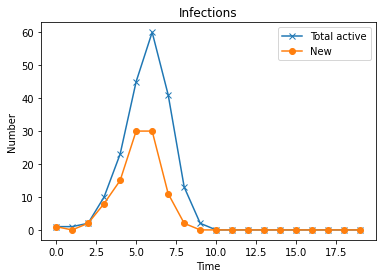

In [ ]:
plot_results(results)